# Let's Build a Question Generation Agent Using LangGraph!
### We will be using the Mistral 8*7B model as our LLM and use the GROQ Api to access the LLM model.

#### Install all the required dependencies and import all the packages

In [96]:
!pip install -qU langchain-groq langgraph langchain

In [97]:
from langgraph.graph import START,END,StateGraph
from IPython.display import Image,display
from typing import Annotated, TypedDict, List
import operator
from langchain_core.messages import HumanMessage, SystemMessage

#### Initialize the LLM

In [98]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

from langchain_groq import ChatGroq

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

Enter your Groq API key:  ········


#### Now we define our State class which is of type TypedDict which helps us type check our inputs to the state object.

In [99]:
class State(TypedDict):
  messages:Annotated[List[str],operator.add]

#### Let's break it down on what this will do. It will create a dictionary something like given below.

In [100]:
#Something like this
{"Messages":["Msg1","Msg2"]}
#Annotated list will add metadata to the dictionary
#Also the list can only contain strings
#The operator.add will append messages to the list

{'Messages': ['Msg1', 'Msg2']}

#### Let’s create our first node. The below function is our first node which will generate content on a topic

In [101]:
def content_generate(state):
  messages=state["messages"]
  #print(messages)
  response=llm.invoke(messages)
  return {"messages":[response]}

#### Let’s create our second node which will generate questions from the content generated from the first node.

In [102]:
def generate_ques(state):
  messages=state["messages"][-1]
  #print(messages)
  content=messages.content
  prompt_template = "Generate two questions based on {content}".format(content=content)
  response=llm.invoke( prompt_template)
  return {"messages":[response]}

#### We will now create an instance of StateGraph. This instance will help us build our graph

In [103]:
builder=StateGraph(State)

#### Now we will add our nodes to the graph using the builder. We have added the two nodes that we created in the beginning using the builder object.

In [104]:
builder.add_node("llm",content_generate)
builder.add_node("create_quest",generate_ques)
#we can see the object being created here <langgraph.graph.state.StateGraph at 0x7e08f2d864d0>

#### Now we set the entry point for the graph execution. We have chosen our first node as the entry point for execution. The set entry point step adds an automatic node called START which will be the first node of our graph

In [105]:
builder.set_entry_point("llm")

#### Now we will add edges to the graph which will define our flow of execution of the graph

In [106]:
builder.add_edge("llm","create_quest")
builder.add_edge("create_quest",END)
#linear execution flow from our first node to second node

#### Now we finally compile the graph

In [107]:
graph=builder.compile()

#### We can now view the graph that was generated

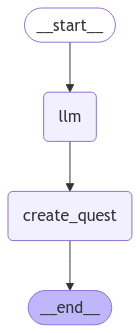

In [108]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Visualization requires additional dependencies.")

#### Now we provide the topic on which the LLMneeds to generate the content

In [109]:
query="Generate content regarding Bengaluru. The content should be of 50 words"
input_ms={"messages":[query]}
#Here we have asked the model to generate content on mars 

#### Now we finally invoke the graph to run the execution. So, first step it would create content on mars in 50 words and then generate 2 question based on the content.

In [110]:
result=graph.invoke(input_ms)
#invoking the execution and storing the result in an object
result

{'messages': ['Generate content regarding Bengaluru. The content should be of 50 words',
  AIMessage(content='Bengaluru, also known as Bangalore, is the capital city of the Indian state of Karnataka. It is known for its pleasant climate, gardens, and parks. As the center of India\'s high-tech industry, Bengaluru is also referred to as the "Silicon Valley of India." The city is home to numerous IT companies, start-ups, and research institutions, making it a major hub for technology and innovation. Bengaluru is also famous for its rich cultural heritage, with numerous temples, palaces, and museums showcasing the city\'s history and traditions. The city\'s vibrant nightlife, diverse culinary scene, and shopping destinations make it a popular tourist destination.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 153, 'prompt_tokens': 24, 'total_tokens': 177, 'completion_time': 0.241898315, 'prompt_time': 0.002678492, 'queue_time': 0.021214988, 'total_time': 0.

#### You can see the dictionary generated with content and questions
You can just access the questions generated using the below code

In [111]:
result["messages"][2].content

'1. How has Bengaluru earned the title of "Silicon Valley of India," and what impact has this had on the city\'s economy and reputation?\n2. Beyond its high-tech industry, how does Bengaluru\'s rich cultural heritage, including temples, palaces, and museums, contribute to the city\'s appeal for both tourists and residents?'